Fit interpretable models to the training set and test on validation sets.

In [1]:
#%matplotlib inline
#%load_ext autoreload
#%autoreload 2

import os
import pickle as pkl
from os.path import join as oj
import numpy as np

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

import imodels
from rulevetting.api import validation
from rulevetting.projects.csi_pecarn.dataset_ll_1129 import Dataset

MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output

/Users/andyshen/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Desktop - Andy’s MacBook Pro/UC Berkeley/STAT 215A/rule-env/lib/python3.8/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
def var_selection(df,method=['rfe',10]):   ## input: a dataframe with outcome as the last column, method: ['rfe',number of
    ## features to choose] or ['lasso',penalty]     output: a dataframe containing the columns we select and the outcome column
    algo=method[0]
    param=method[1]
    X=df.drop(columns=['outcome'])
    y=df.outcome
    if algo=='rfe':
        mymodel=LogisticRegression()
        myrfe = RFE(mymodel,n_features_to_select=param)
        myfit = myrfe.fit(X, y)
        index=np.append(myfit.support_,True)
    
    elif algo=='lasso':
        mylasso = LogisticRegression(penalty='l1', solver='liblinear',C=param)   ## for example C=0.1
        myfit=mylasso.fit(X, y)
        
        index=np.append(myfit.coef_[0]!=0,True)
    
    
    return index
        

In [3]:
df_train, df_tune, _ = Dataset().get_data(load_csvs=True)


df_train=df_train.drop(columns=['PosMidNeckTenderness2','PainNeck2','PtAmbulatoryPriorArrival','HeadFirst','PtCompPainNeck',
                         'PtTenderNeck','TotalGCS'])
df_tune=df_tune.drop(columns=['PosMidNeckTenderness2','PainNeck2','PtAmbulatoryPriorArrival','HeadFirst','PtCompPainNeck',
                         'PtTenderNeck','TotalGCS'])
_=_.drop(columns=['PosMidNeckTenderness2','PainNeck2','PtAmbulatoryPriorArrival','HeadFirst','PtCompPainNeck',
                         'PtTenderNeck','TotalGCS'])


'''
df_train=df_train[['AlteredMentalStatus','LOC','ambulatory','FocalNeuroFindings','PainNeck','PosMidNeckTenderness',
'TenderNeck','Torticollis','SubInj_Head','SubInj_Face','SubInj_Ext','SubInj_TorsoTrunk',
'Predisposed','HighriskDiving','HighriskFall','HighriskHanging','HighriskHitByCar','HighriskMVC',
'HighriskOtherMV','AxialLoadAnyDoc','axialloadtop','outcome']]

df_tune=df_tune[['AlteredMentalStatus','LOC','ambulatory','FocalNeuroFindings','PainNeck','PosMidNeckTenderness',
'TenderNeck','Torticollis','SubInj_Head','SubInj_Face','SubInj_Ext','SubInj_TorsoTrunk',
'Predisposed','HighriskDiving','HighriskFall','HighriskHanging','HighriskHitByCar','HighriskMVC',
'HighriskOtherMV','AxialLoadAnyDoc','axialloadtop','outcome']]

_=_[['AlteredMentalStatus','LOC','ambulatory','FocalNeuroFindings','PainNeck','PosMidNeckTenderness',
'TenderNeck','Torticollis','SubInj_Head','SubInj_Face','SubInj_Ext','SubInj_TorsoTrunk',
'Predisposed','HighriskDiving','HighriskFall','HighriskHanging','HighriskHitByCar','HighriskMVC',
'HighriskOtherMV','AxialLoadAnyDoc','axialloadtop','outcome']]

'''







"\ndf_train=df_train[['AlteredMentalStatus','LOC','ambulatory','FocalNeuroFindings','PainNeck','PosMidNeckTenderness',\n'TenderNeck','Torticollis','SubInj_Head','SubInj_Face','SubInj_Ext','SubInj_TorsoTrunk',\n'Predisposed','HighriskDiving','HighriskFall','HighriskHanging','HighriskHitByCar','HighriskMVC',\n'HighriskOtherMV','AxialLoadAnyDoc','axialloadtop','outcome']]\n\ndf_tune=df_tune[['AlteredMentalStatus','LOC','ambulatory','FocalNeuroFindings','PainNeck','PosMidNeckTenderness',\n'TenderNeck','Torticollis','SubInj_Head','SubInj_Face','SubInj_Ext','SubInj_TorsoTrunk',\n'Predisposed','HighriskDiving','HighriskFall','HighriskHanging','HighriskHitByCar','HighriskMVC',\n'HighriskOtherMV','AxialLoadAnyDoc','axialloadtop','outcome']]\n\n_=_[['AlteredMentalStatus','LOC','ambulatory','FocalNeuroFindings','PainNeck','PosMidNeckTenderness',\n'TenderNeck','Torticollis','SubInj_Head','SubInj_Face','SubInj_Ext','SubInj_TorsoTrunk',\n'Predisposed','HighriskDiving','HighriskFall','HighriskHanging

In [4]:

def predict_and_save(model, model_name='decision_tree'):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes



def model_valid(max_num=20,model_name='decision_tree'):
    '''use validation set to select # of features'''
    
    record=np.zeros(max_num)
    sensitivity=np.zeros(max_num)
    for num in range(1,max_num+1):
        index=var_selection(df_train,method=['rfe',num])
        loc_train=df_train.loc[:,index]
        loc_tune=df_tune.loc[:,index]
        loc_=_.loc[:,index]
        X_train = loc_train.drop(columns=outcome_def)
        y_train = loc_train[outcome_def].values
        X_tune = loc_tune.drop(columns=outcome_def)
        y_tune = loc_tune[outcome_def].values
        
        if model_name=='decision_tree':
            model = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 1e3})
            model.fit(X_train, y_train)
        elif model_name=='logistic':
            model= LogisticRegression()
            model.fit(X_train, y_train)
        elif model_name=='adaboost':
            model= AdaBoostClassifier(n_estimators=50, learning_rate=1)
            model.fit(X_train, y_train)
            
        
        
        stats, threshes = validation.all_stats_curve(y_tune, model.predict_proba(X_tune)[:, 1],
                                                     plot=False)
        sens=stats['sens']
        spec=stats['spec']
        if sens[0]<0.98:
            record[num-1]=0.
            sensitivity[num-1]=sens[0]
            continue
        j=0
        while sens[j]>0.98:
            #print([j, sens[j]], spec[j])
            #print(sens[j])
            cur_pec=spec[j]
            
            j+=1
        record[num-1]=cur_pec
        sensitivity[num-1]=sens[j]
        
    print(record)
    print(sensitivity)
    return np.argmax(record)+1    ## output the optimal number of features via validation 
    
        
        
        
        
        
        
        
        

In [5]:
print(model_valid(20,model_name='adaboost'))   ## output zero when sens<.98, otherwise output spec (adaboost,decision_tree,logistic)

100%|███████████████████████████████████████| 220/220 [00:00<00:00, 4360.85it/s]

[0.         0.         0.         0.         0.         0.75719424
 0.75719424 0.75719424 0.76798561 0.76798561 0.76798561 0.76258993
 0.76258993 0.78776978 0.78597122 0.78956835 0.73741007 0.73741007
 0.75719424 0.75719424]
[0.87850467 0.92523364 0.93457944 0.97196262 0.97196262 0.97196262
 0.97196262 0.97196262 0.96261682 0.96261682 0.96261682 0.96261682
 0.97196262 0.96261682 0.97196262 0.97196262 0.97196262 0.97196262
 0.97196262 0.97196262]
16


In [6]:
print(model_valid(20,model_name='decision_tree'))   ## output zero when sens<.98, otherwise output spec (adaboost,decision_tree,logistic)

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 3076.13it/s]

[0.         0.         0.         0.         0.         0.76438849
 0.76438849 0.73920863 0.75359712 0.75       0.02517986 0.02517986
 0.02517986 0.02517986 0.02517986 0.02697842 0.02697842 0.02877698
 0.02877698 0.02877698]
[0.87850467 0.92523364 0.93457944 0.97196262 0.97196262 0.95327103
 0.95327103 0.95327103 0.95327103 0.95327103 0.94392523 0.94392523
 0.94392523 0.94392523 0.94392523 0.94392523 0.94392523 0.94392523
 0.94392523 0.94392523]
6


In [7]:
## select number of parameters via the validation set

print(model_valid(30,model_name='logistic'))   ## output zero when sens<.98, otherwise output spec (adaboost,decision_tree,logistic)


100%|███████████████████████████████████████| 413/413 [00:00<00:00, 4376.44it/s]

[0.         0.         0.         0.         0.         0.75719424
 0.75719424 0.75719424 0.76798561 0.76618705 0.76618705 0.76618705
 0.78057554 0.76978417 0.78776978 0.75899281 0.76079137 0.77877698
 0.78597122 0.78956835 0.79136691 0.78417266 0.78417266 0.75899281
 0.76079137 0.76079137 0.76438849 0.76438849 0.76618705 0.77158273]
[0.87850467 0.92523364 0.93457944 0.97196262 0.97196262 0.97196262
 0.97196262 0.97196262 0.96261682 0.96261682 0.96261682 0.96261682
 0.96261682 0.96261682 0.96261682 0.97196262 0.97196262 0.97196262
 0.97196262 0.97196262 0.97196262 0.97196262 0.97196262 0.97196262
 0.97196262 0.97196262 0.97196262 0.97196262 0.97196262 0.97196262]
21


In [8]:






index=var_selection(df_train,method=['rfe',9])
#index=var_selection(df_train,method=['lasso',.1])


print(df_train.columns[index])

df_train=df_train.loc[:,index]
df_tune=df_tune.loc[:,index]
_=_.loc[:,index]





X_train = df_train.drop(columns=outcome_def)
y_train = df_train[outcome_def].values
X_tune = df_tune.drop(columns=outcome_def)
y_tune = df_tune[outcome_def].values
processed_feats = df_train.keys().values.tolist()

feature_names=processed_feats



    
    

Index(['ArrPtIntub', 'DxCspineInjury', 'FocalNeuroFindings', 'HighriskDiving',
       'IntervForCervicalStab', 'PtExtremityWeakness', 'PtSensoryLoss',
       'PtTenderExt', 'SubInj_TorsoTrunk', 'outcome'],
      dtype='object')


In [9]:
#print(help(DecisionTreeClassifier))

# fit simple models

**decision tree**

100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 2585.43it/s]

{'sens': [1.0, 0.9813084112149533, 0.9532710280373832, 0.9252336448598131, 0.9158878504672897, 0.8411214953271028, 0.8130841121495327, 0.8037383177570093, 0.5887850467289719, 0.5327102803738317, 0.5046728971962616, 0.3925233644859813, 0.04672897196261682, 0.0], 'spec': [0.014388489208633094, 0.7535971223021583, 0.8111510791366906, 0.8435251798561151, 0.8633093525179856, 0.8723021582733813, 0.8992805755395683, 0.9028776978417267, 0.987410071942446, 0.9892086330935251, 0.9892086330935251, 0.9910071942446043, 1.0, 1.0], 'ppv': [0.1633587786259542, 0.43388429752066116, 0.4927536231884058, 0.532258064516129, 0.5632183908045977, 0.5590062111801242, 0.6083916083916084, 0.6142857142857143, 0.9, 0.9047619047619048, 0.9, 0.8936170212765957, 1.0, nan], 'npv': [1.0, 0.995249406175772, 0.9890350877192983, 0.9832285115303984, 0.9815950920245399, 0.9661354581673307, 0.9615384615384616, 0.9598470363288719, 0.9258010118043845, 0.9166666666666666, 0.912106135986733, 0.8944805194805194, 0.844984802431610

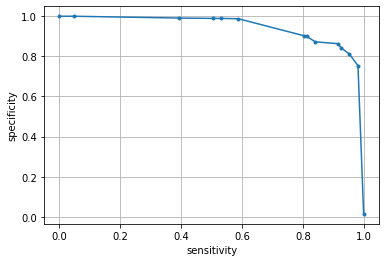

<Figure size 432x288 with 0 Axes>

In [13]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 1e3})
dt.fit(X_train, y_train)

## fit logitstic
#dt= LogisticRegression()
#dt.fit(X_train, y_train)

## fit adaboost
#dt= AdaBoostClassifier(n_estimators=50, learning_rate=1)
#dt.fit(X_train, y_train)


stats, threshes = predict_and_save(dt, model_name='decision_tree')
print(stats,threshes)
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))

plt.show()
plt.savefig("tree-roc.png", dpi='figure', format=None, metadata=None,
        bbox_inches=None, pad_inches=0,
        facecolor='auto', edgecolor='auto',
        backend=None)



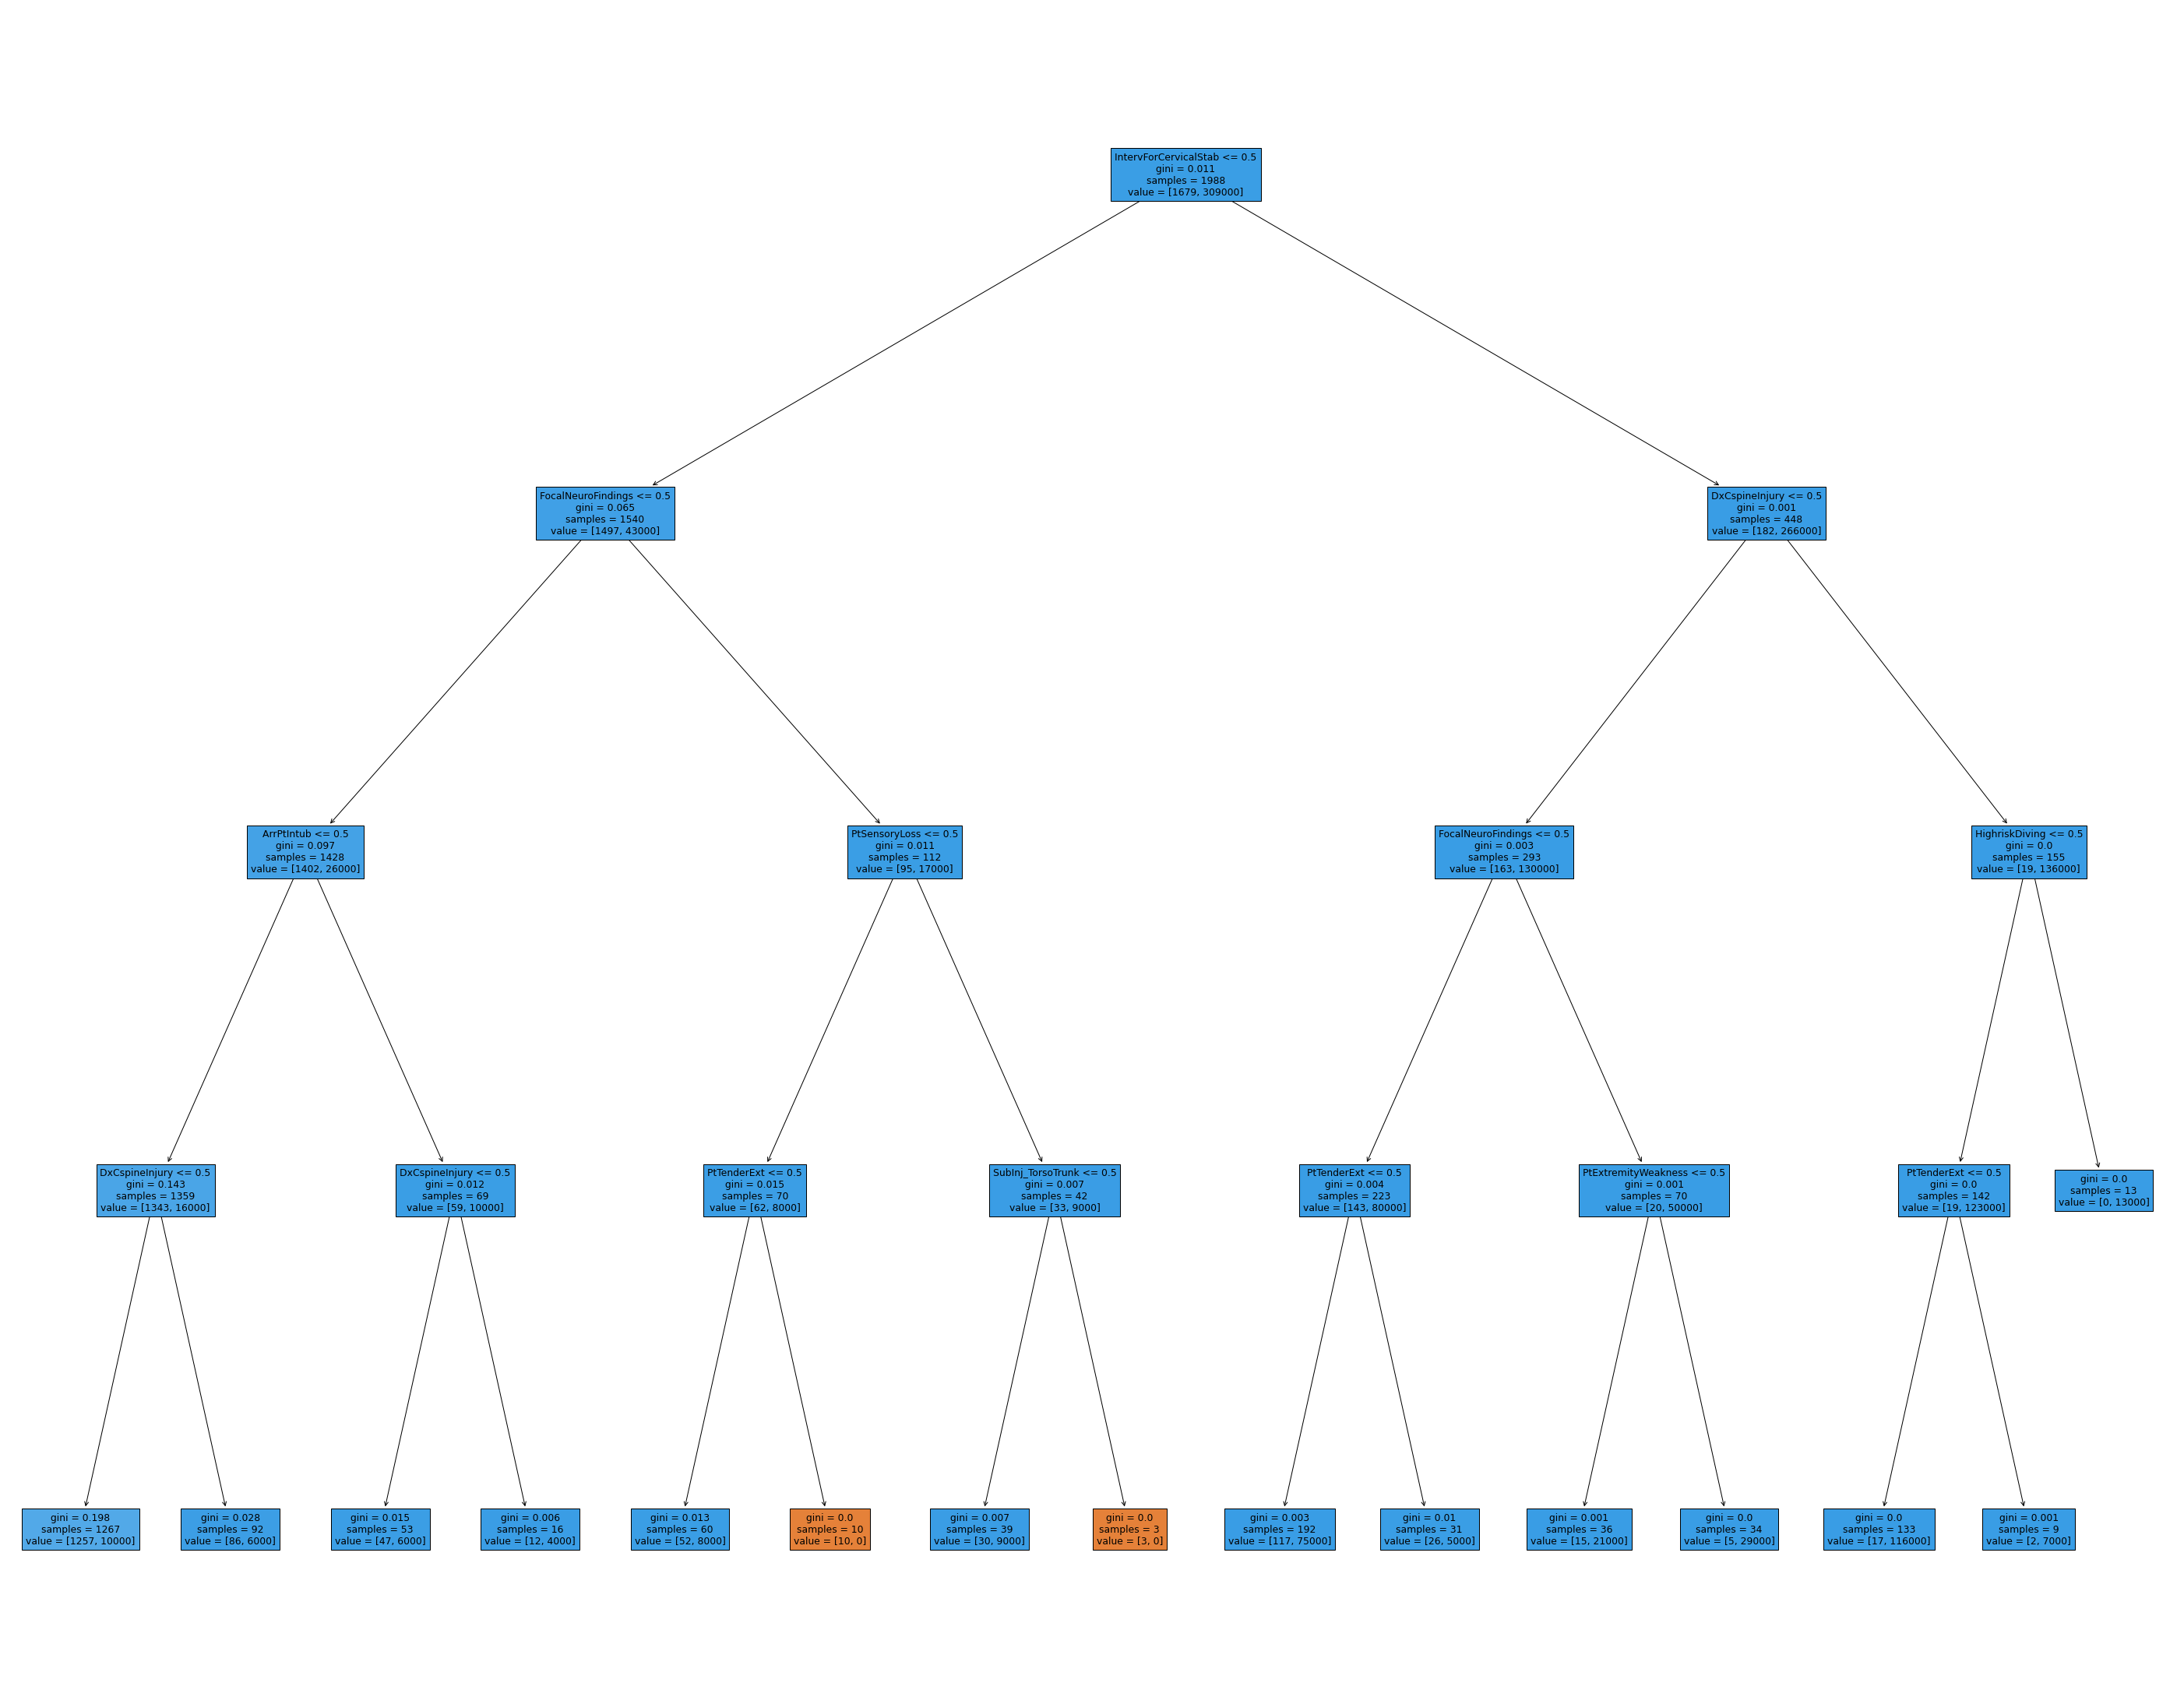

In [11]:
fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 3942.25it/s]

{'sens': [1.0, 0.9906542056074766, 0.9906542056074766, 0.9906542056074766, 0.9906542056074766, 0.9813084112149533, 0.9813084112149533, 0.9813084112149533, 0.9626168224299065, 0.9532710280373832, 0.9532710280373832, 0.9345794392523364, 0.9345794392523364, 0.9252336448598131, 0.9158878504672897, 0.9065420560747663, 0.9065420560747663, 0.9065420560747663, 0.9065420560747663, 0.8411214953271028, 0.8317757009345794, 0.822429906542056, 0.6915887850467289, 0.6822429906542056, 0.6728971962616822, 0.6728971962616822, 0.6635514018691588, 0.6448598130841121, 0.616822429906542, 0.5887850467289719, 0.5607476635514018, 0.5420560747663551, 0.5233644859813084, 0.4953271028037383, 0.308411214953271, 0.29906542056074764, 0.2897196261682243, 0.21495327102803738, 0.18691588785046728, 0.17757009345794392, 0.1588785046728972, 0.1308411214953271, 0.09345794392523364, 0.07476635514018691, 0.06542056074766354, 0.056074766355140186, 0.009345794392523364, 0.0], 'spec': [0.14568345323741008, 0.7068345323741008, 0

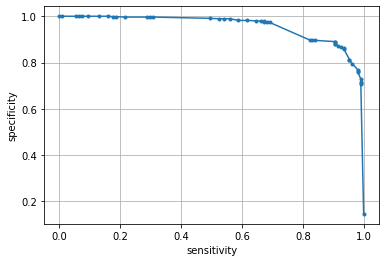

AttributeError: 'LogisticRegression' object has no attribute 'tree_'

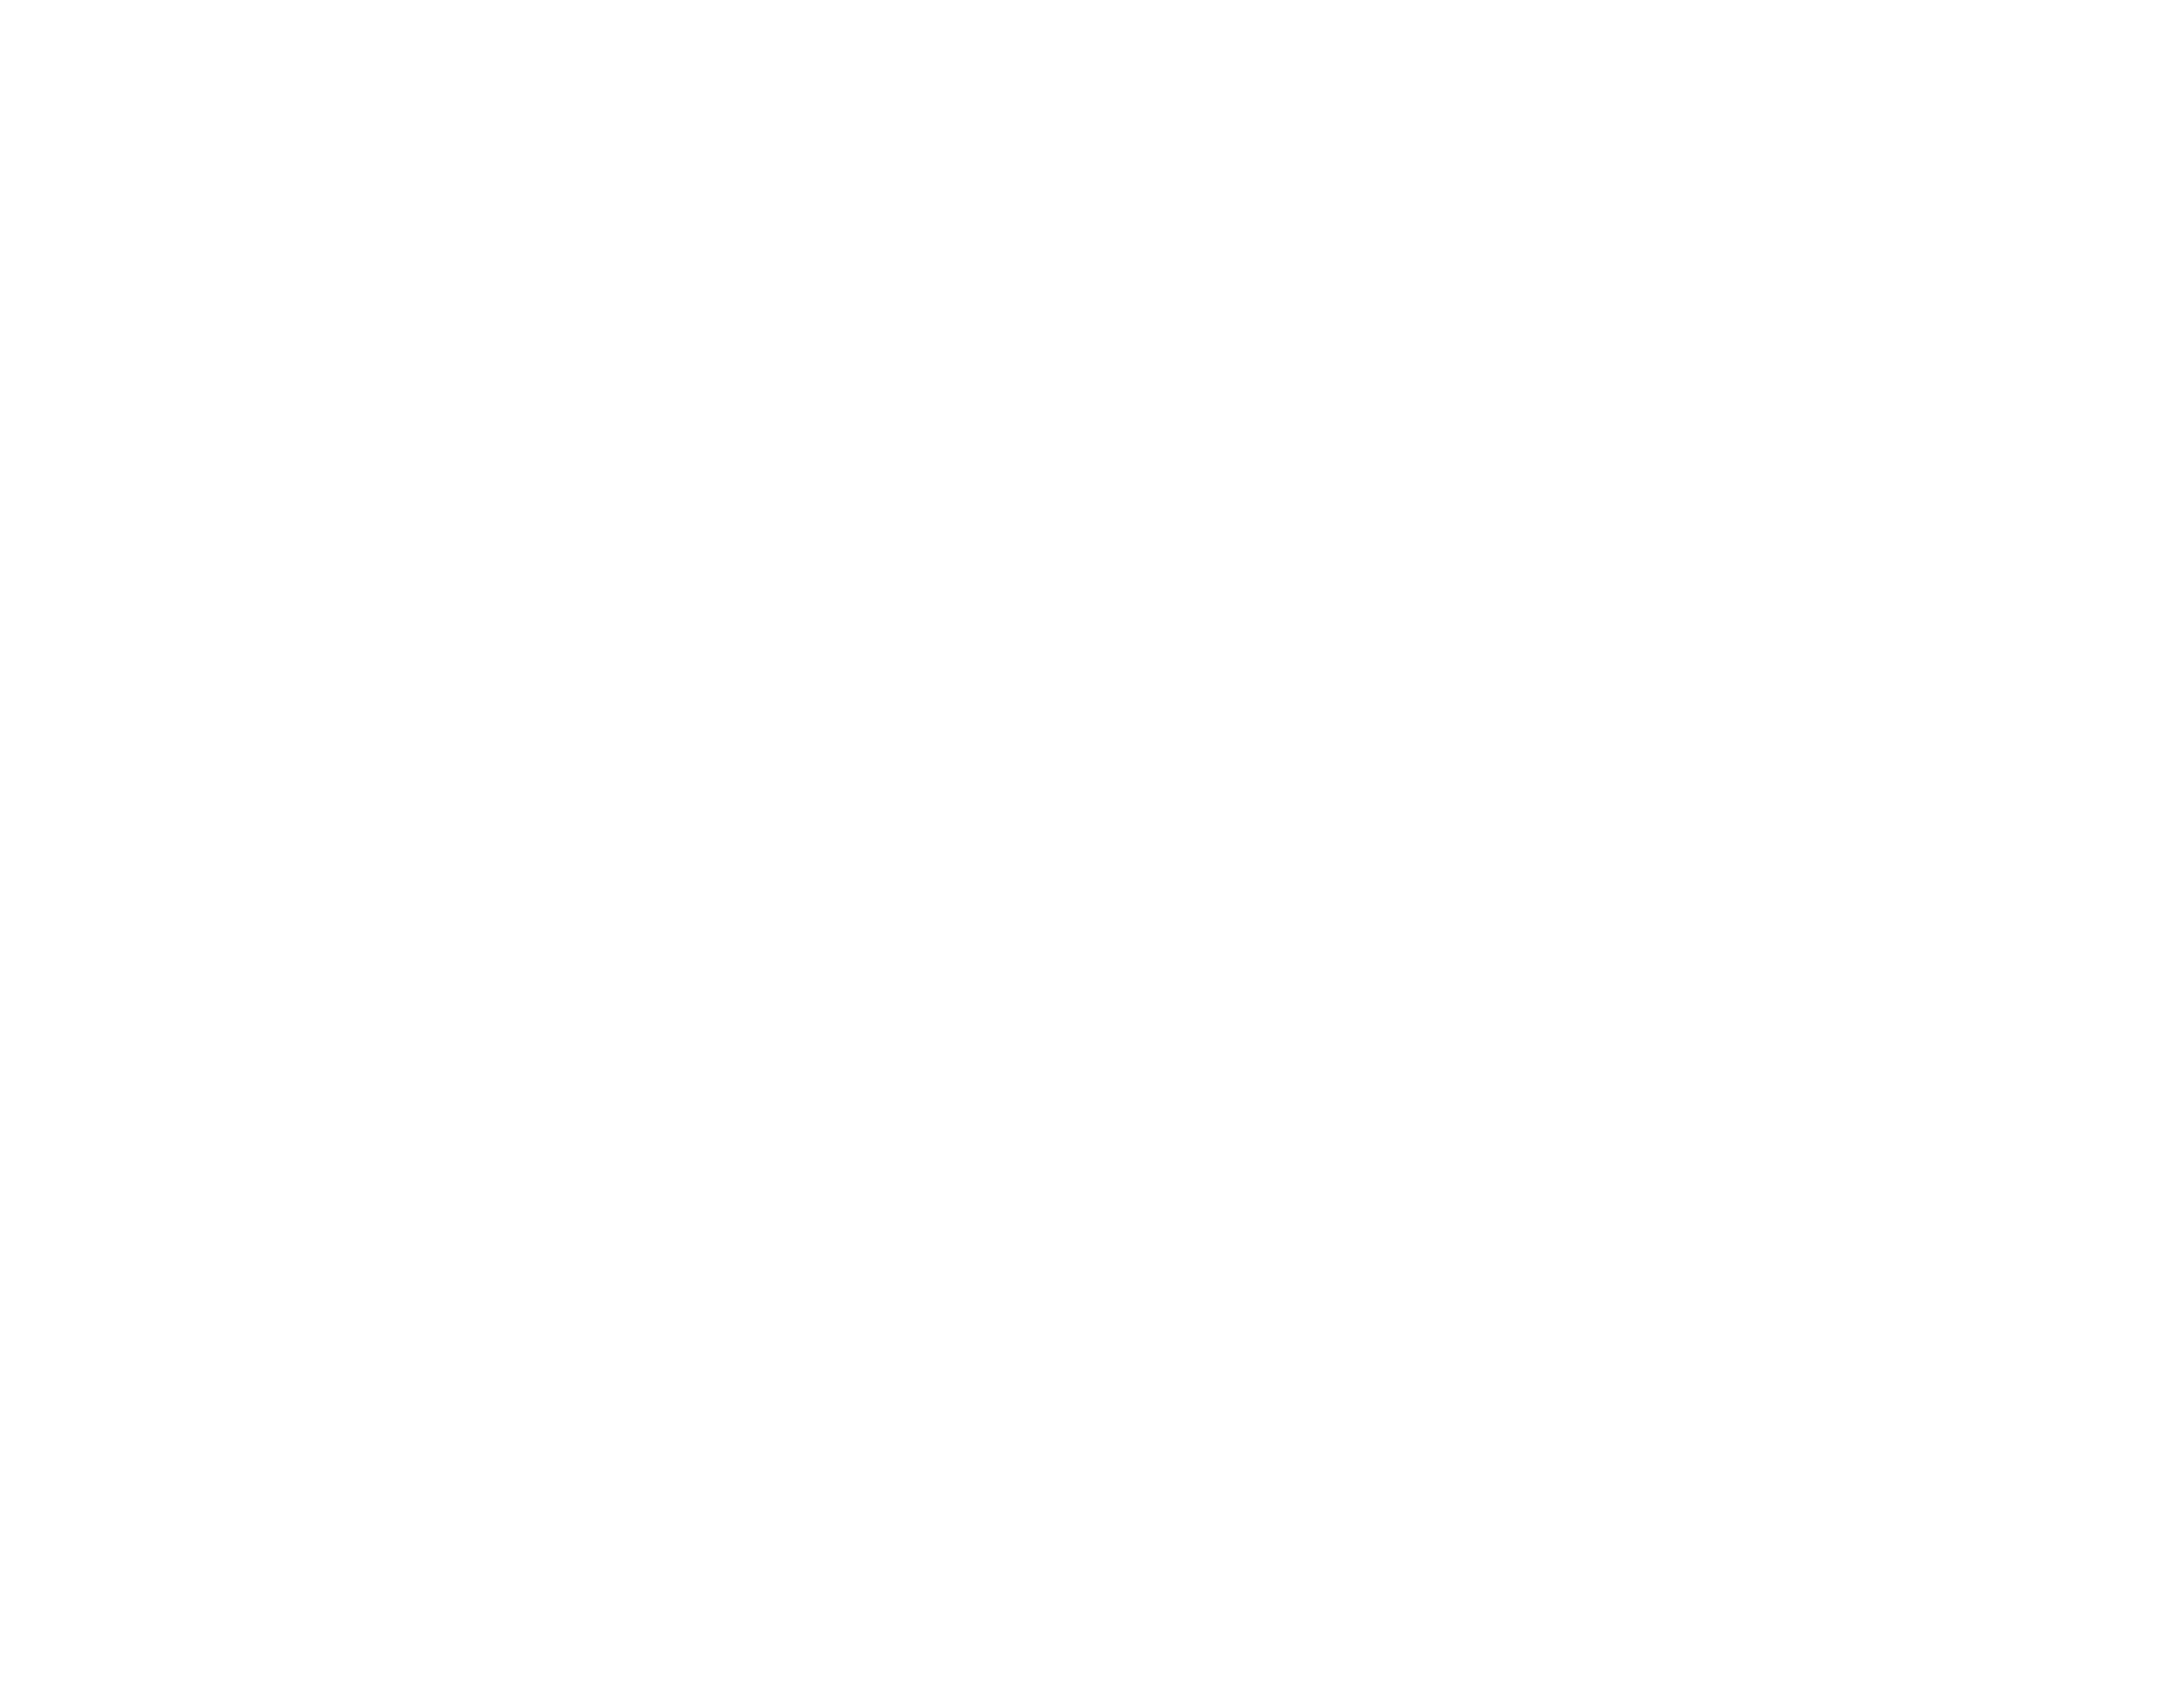

In [14]:
# fit decition tree
#dt = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 1e3})
#dt.fit(X_train, y_train)

## fit logitstic
dt= LogisticRegression()
dt.fit(X_train, y_train)

## fit adaboost
#dt= AdaBoostClassifier(n_estimators=50, learning_rate=1)
#dt.fit(X_train, y_train)


stats_lr, threshes_lr = predict_and_save(dt, model_name='logistic')
print(stats_lr, "\n")
print(threshes_lr)
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))

plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

100%|█████████████████████████████████████████| 48/48 [00:00<00:00, 4163.43it/s]

{'sens': [1.0, 0.9906542056074766, 0.9906542056074766, 0.9906542056074766, 0.9906542056074766, 0.9813084112149533, 0.9813084112149533, 0.9813084112149533, 0.9626168224299065, 0.9439252336448598, 0.9345794392523364, 0.9345794392523364, 0.9345794392523364, 0.9252336448598131, 0.9158878504672897, 0.9065420560747663, 0.9065420560747663, 0.9065420560747663, 0.9065420560747663, 0.8411214953271028, 0.8317757009345794, 0.7009345794392523, 0.6915887850467289, 0.6822429906542056, 0.6728971962616822, 0.6635514018691588, 0.6448598130841121, 0.6448598130841121, 0.616822429906542, 0.5887850467289719, 0.5607476635514018, 0.5327102803738317, 0.34579439252336447, 0.32710280373831774, 0.308411214953271, 0.2803738317757009, 0.205607476635514, 0.19626168224299065, 0.18691588785046728, 0.16822429906542055, 0.1308411214953271, 0.12149532710280374, 0.102803738317757, 0.07476635514018691, 0.028037383177570093, 0.018691588785046728, 0.009345794392523364, 0.0], 'spec': [0.14568345323741008, 0.7068345323741008, 

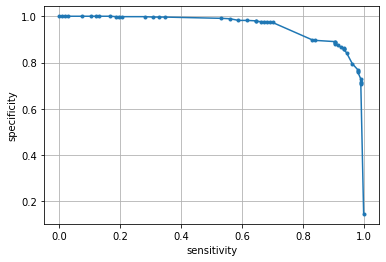

AttributeError: 'AdaBoostClassifier' object has no attribute 'tree_'

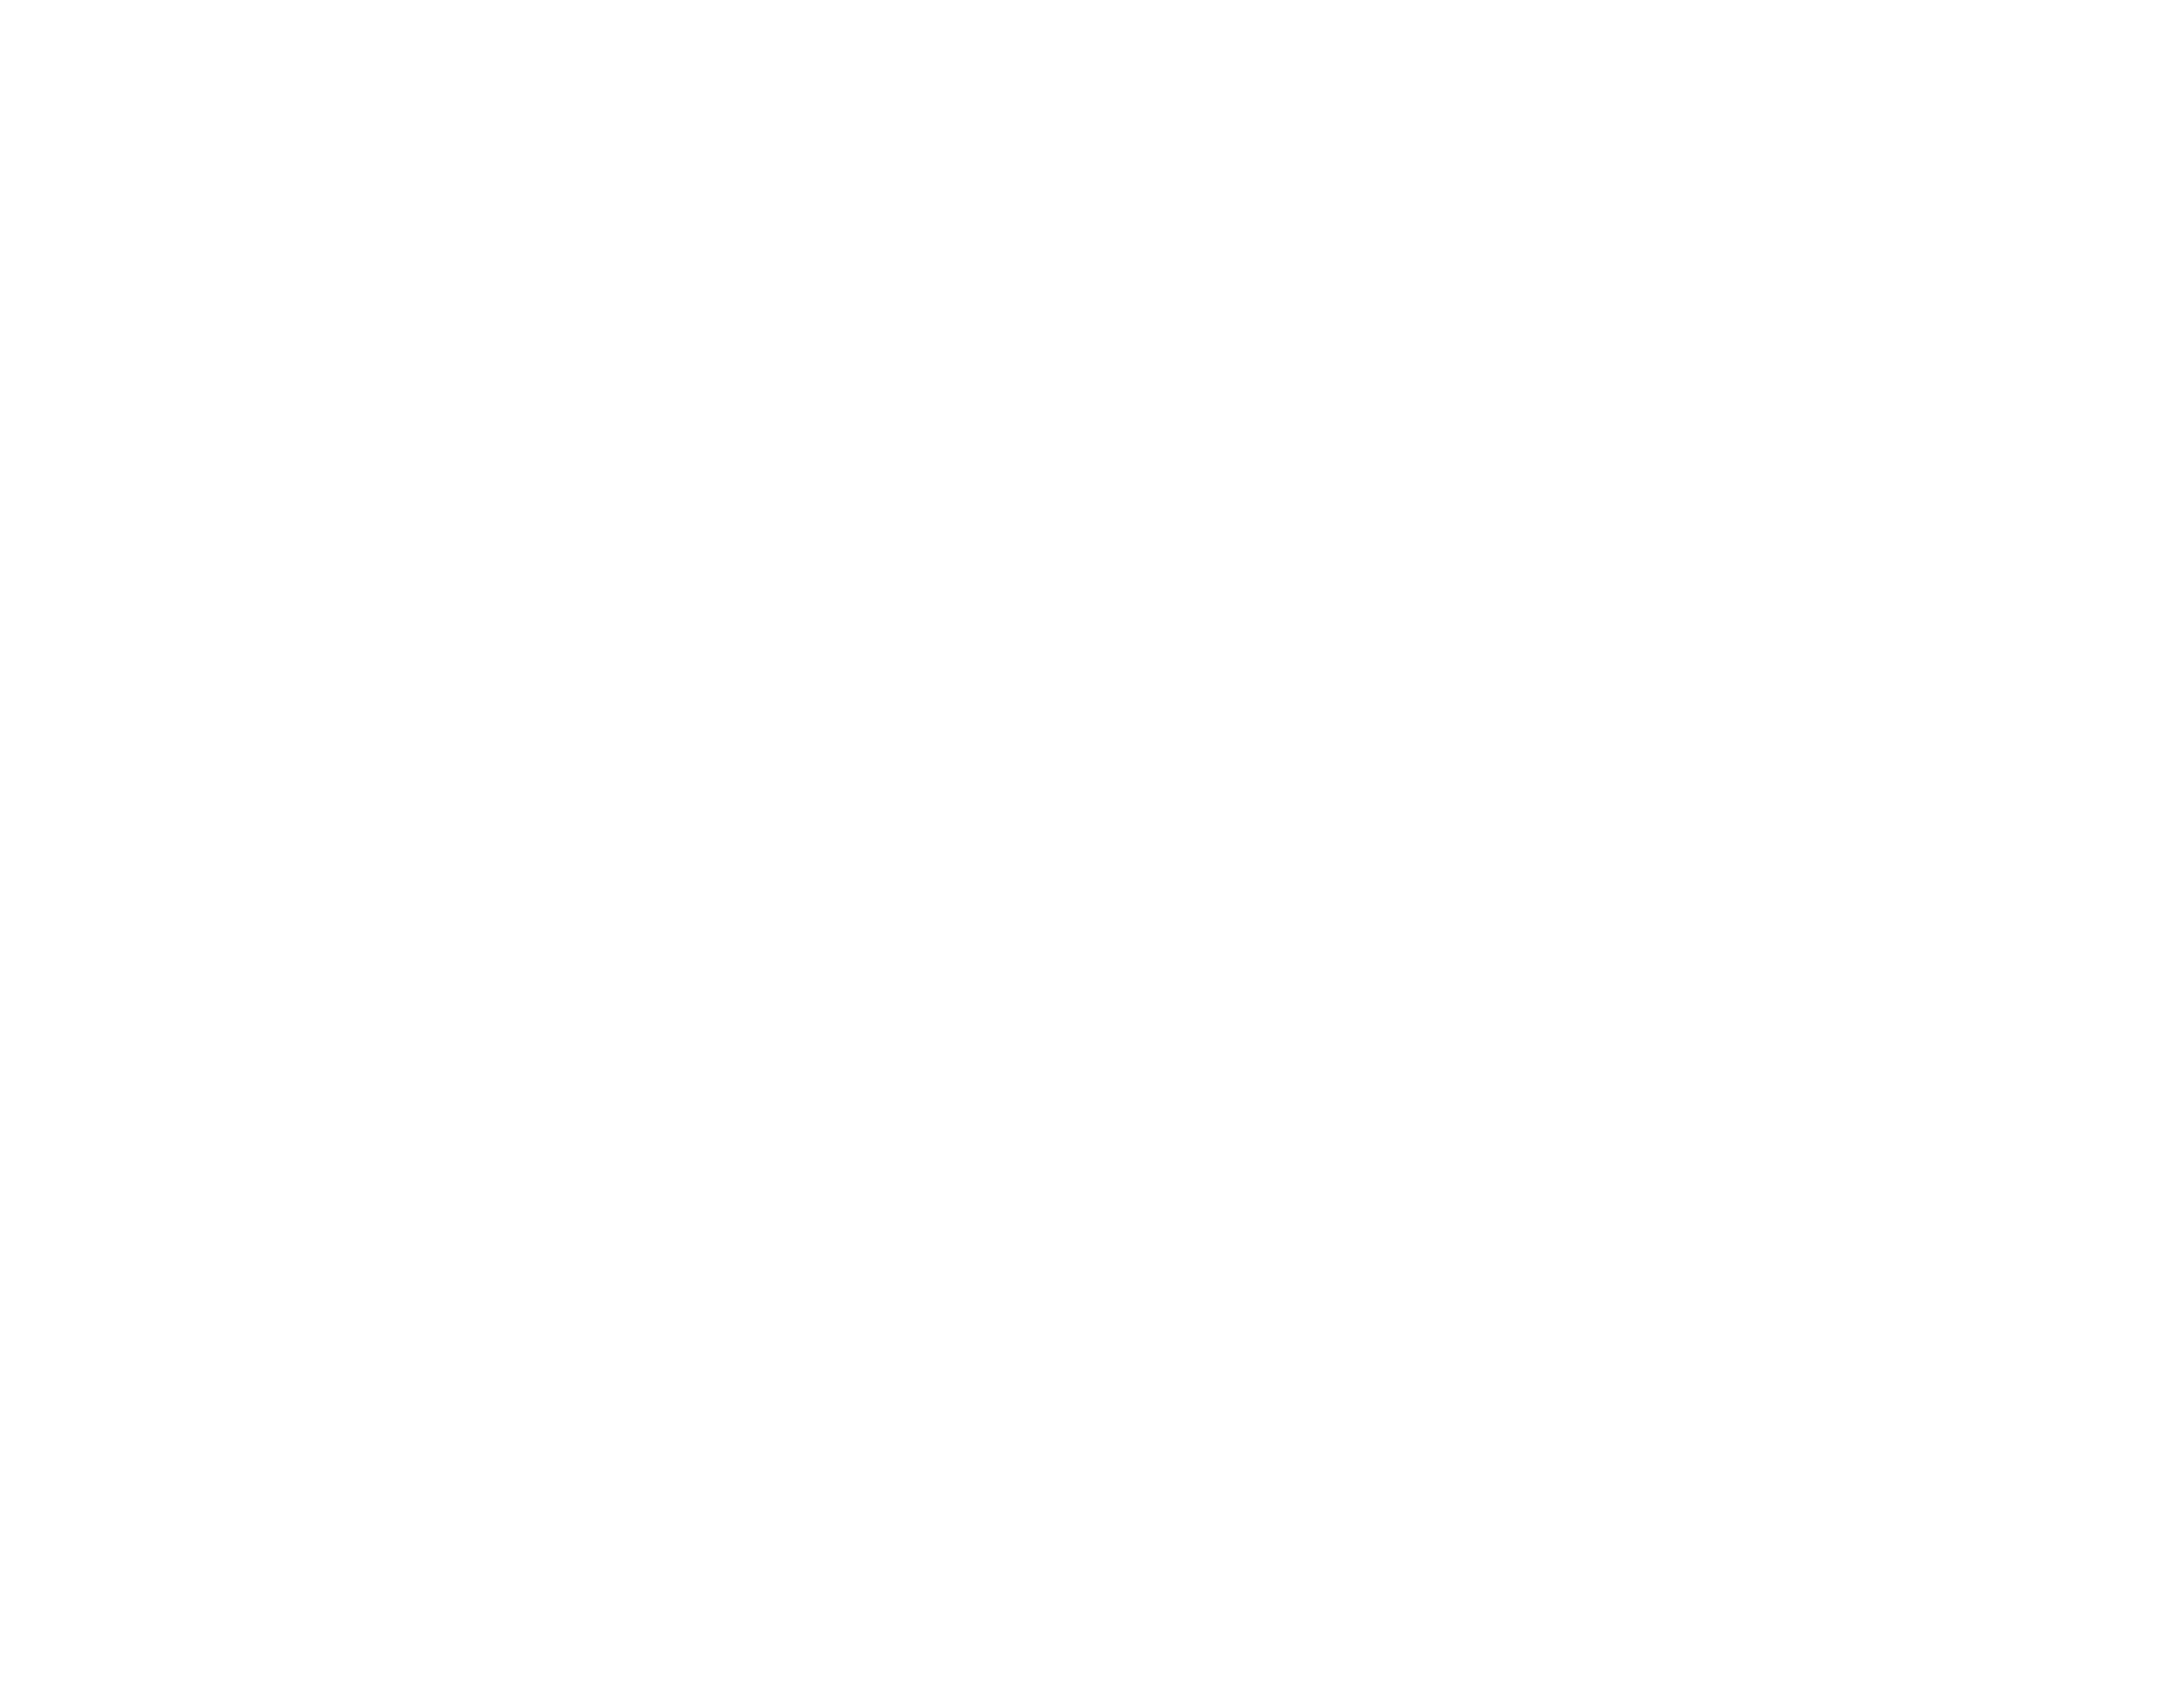

In [15]:
# fit decition tree
#dt = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 1e3})
#dt.fit(X_train, y_train)

## fit logitstic
#dt= LogisticRegression()
#dt.fit(X_train, y_train)

## fit adaboost
dt= AdaBoostClassifier(n_estimators=100, learning_rate=1)
dt.fit(X_train, y_train)


stats_ab, threshes_ab = predict_and_save(dt, model_name='adaboost')
print(stats_ab, "\n")
print(threshes_ab)
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))

plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

In [44]:
(np.asarray(stats_lr["sens"]) - np.asarray(stats_ab["sens"])) * 1000

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   9.34579439,  18.69158879,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        , 121.4953271 ,   0.        ,   0.        ,
         0.        ,   9.34579439,  18.69158879,   0.        ,
         0.        ,   0.        ,   0.        ,   9.34579439,
       177.57009346, 168.22429907,   0.        ,  18.69158879,
        84.11214953,  18.69158879,   0.        ,   9.34579439,
        28.03738318,   9.34579439,  -9.34579439,   0.        ,
        37.38317757,  37.38317757,   0.        ,   0.        ])

**bayesian rule list (this one is slow)**

In [9]:
np.random.seed(13)
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training bayesian_rule_list...')
brl = imodels.BayesianRuleListClassifier(listlengthprior=2, max_iter=10000, class1label="IwI", verbose=False)
brl.fit(X_train, y_train, feature_names=feature_names)
stats, threshes = predict_and_save(brl, model_name='bayesian_rule_list')
print(brl)

training bayesian_rule_list...


/Users/llc/Desktop/rule-env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


KeyError: 'X_57_0.0'

In [47]:
print(brl)

(Untrained RuleListClassifier)


**rulefit**

100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 3593.21it/s]


'\ndef print_best(sens, spec):\n    idxs = np.array(sens) > 0.9\n    print(np.array(sens)[idxs], np.array(spec)[idxs])\nprint_best(sens, spec)\n'

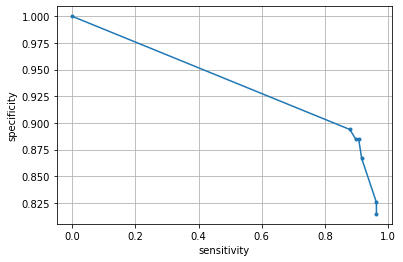

In [23]:
# fit a rulefit model
np.random.seed(13)
rulefit = imodels.RuleFitRegressor(max_rules=4)
rulefit.fit(X_train, y_train, feature_names=feature_names)

# preds = rulefit.predict(X_test)
stats, threshes = predict_and_save(rulefit, model_name='rulefit')
'''
def print_best(sens, spec):
    idxs = np.array(sens) > 0.9
    print(np.array(sens)[idxs], np.array(spec)[idxs])
print_best(sens, spec)
'''

In [20]:
# pd.reset_option('display.max_colwidth')
rulefit.visualize()

,rule,coef
10,AbdTrauma_no,-0.01
11,AbdTrauma_or_SeatBeltSign_no,-0.02
12,AbdTrauma_or_SeatBeltSign_yes,0.00
29,GCSScore,-0.01
55,VomitWretch_no,-0.00
59,DecrBreathSound_yes <= 0.5 and AbdDistention_yes <= 0.5,-0.01
60,AbdDistention_yes <= 0.5 and AbdTenderDegree_Severe <= 0.5,-0.07
58,GCSScore > 9.5 and AbdTenderDegree_Severe <= 0.5,-0.01
61,VomitWretch_no > 0.5,-0.00


**greedy (CART) rule list**

/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/chandan/venvs/rule-vetting/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1109.18it/s]

mean 0.016 (7226 pts)
if AbdDistention >= 1.0 then 0.175 (166 pts)
mean 0.012 (7060 pts)
if feat 8 >= 1.0 then 0.121 (223 pts)
mean 0.009 (6837 pts)
if feat 50 >= 1.0 then 0.044 (615 pts)
mean 0.005 (6222 pts)
if feat 46 >= 1.0 then 0.029 (307 pts)
mean 0.004 (5915 pts)
if feat 6 >= 1.0 then 0.012 (805 pts)
mean 0.003 (5110 pts)
if feat 43 >= 3.0 then 0.02 (101 pts)
mean 0.002 (5009 pts)
if feat 18 >= 17.0 then 0.009 (459 pts)
mean 0.002 (4550 pts)
if feat 33 >= 1.0 then 0.024 (42 pts)
mean 0.001 (4508 pts)
if feat 35 >= 1.0 then 0.007 (302 pts)



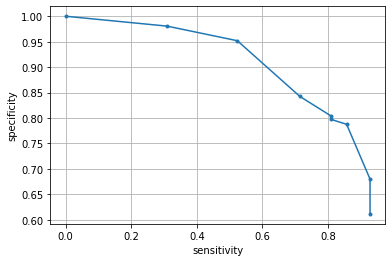

In [24]:
class_weight = {0: 1, 1: 100}
d = imodels.GreedyRuleListClassifier(max_depth=9, class_weight=class_weight, criterion='neg_corr')
d.fit(X_train, y_train, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(d, model_name='grl')
# d.print_list()
print(d)

**rf**

In [25]:
# # specify a decision tree with a maximum depth
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# sens, spec, threshes = predict_and_save(rf, model_name='rf')
# # sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1])
# imps = rf.feature_importances_.round(3)
# args = np.argsort(imps)
# imps = imps[args]
# feats = np.array(processed_feats)[args]
# for imp, feat in zip(imps, feats):
#     print(feat, imp)

# look at all the results

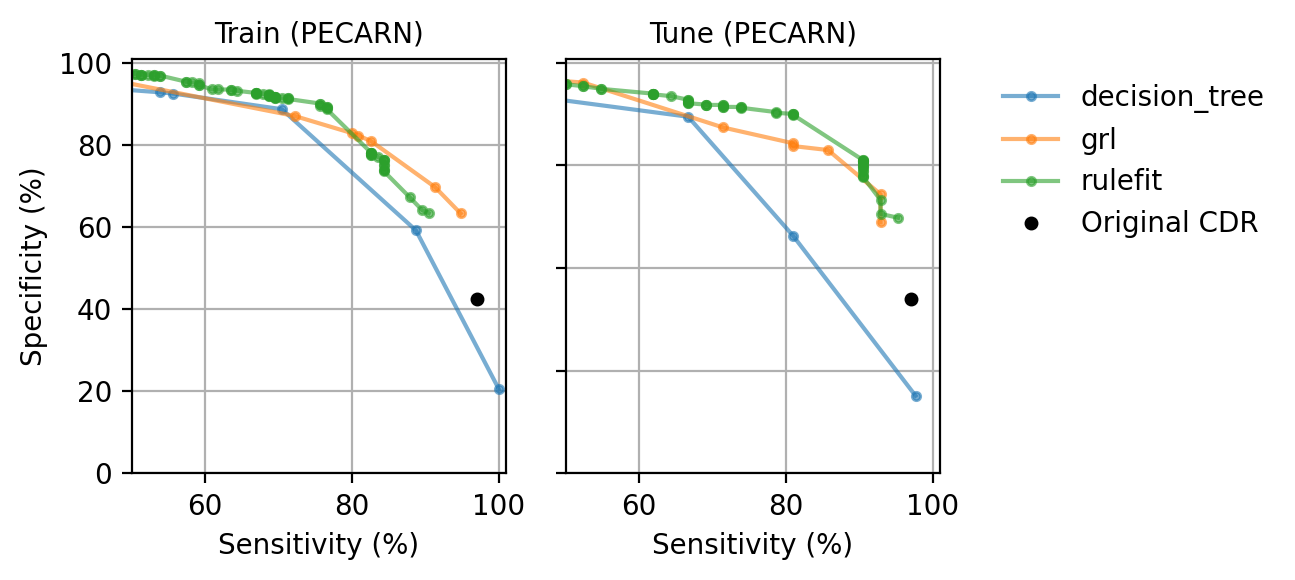

"x\nplt.figure(dpi=200, figsize=(C * 6, R * 6))\nfor i, suffix in enumerate(suffixes):\n    plt.subplot(R, C, i + 1)\n    plot_metrics(suffix, title=titles[i])\n    plt.xlim((80, 101))\n    plt.ylim((25, 70))\nplt.subplot(R, C, 1)    \nplt.legend()\nplt.tight_layout()\nviz.savefig('metrics_3_splits_zoom')\nplt.show()\nplt.legend(bbox_to_anchor=(1.05, 1.05))\n"

In [31]:
def plot_metrics(suffix, title=None, fs=15):
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                #         print(r)
                #                 print(r.keys())

                threshes = np.array(r['threshes' + suffix])
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                plt.plot(100 * sens, 100 * spec, 'o-', label=fname[:-4], alpha=0.6, markersize=3)
                plt.xlabel('Sensitivity (%)', fontsize=fs)
                plt.ylabel('Specificity (%)', fontsize=fs)
                s = suffix[1:]
                if title is None:
                    plt.title(f'{s}\n{data_sizes[s][0]} IAI-I / {data_sizes[s][1]}')
                else:
                    plt.title(title, fontsize=fs)

                # print best results
                if suffix == '_test2':
                    idxs = (sens > 0.95) & (spec > 0.43)
                    if np.sum(idxs) > 0:
                        idx_max = np.argmax(spec[idxs])
                        print(fname, f'{100 * sens[idxs][idx_max]:0.2f} {100 * spec[idxs][idx_max]:0.2f}')

    if suffix == '_test2':
        plt.plot(96.77, 43.98, 'o', color='black', label='Original CDR', ms=4)
    else:
        plt.plot(97.0, 42.5, 'o', color='black', label='Original CDR', ms=4)
    plt.grid()


suffixes = ['_train', '_tune']  # _train, _test1, _test2, _cv
titles = ['Train (PECARN)', 'Tune (PECARN)']
R, C = 1, len(suffixes)
plt.figure(dpi=200, figsize=(C * 2.5, R * 3), facecolor='w')
fs = 10
for i, suffix in enumerate(suffixes):
    ax = plt.subplot(R, C, i + 1)
    plot_metrics(suffix, title=titles[i], fs=fs)
    if i > 0:
        plt.ylabel('')
        plt.yticks([0, 25, 50, 75, 100], labels=[''] * 5)
    #         ax.yaxis.set_visible(False)
    plt.xlim((50, 101))
    plt.ylim((0, 101))
plt.tight_layout()
# plt.subplot(R, C, 1)
# plt.legend(fontsize=20)
plt.legend(bbox_to_anchor=(1.1, 1), fontsize=fs, frameon=False)
plt.savefig('figs/metrics_3_splits')
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1591.61it/s]


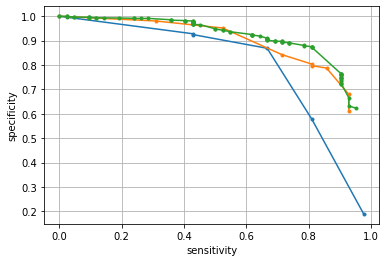

In [37]:
def print_metrics(suffix):
    vals = {s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'brier_score', 'f1']}
    fnames = []
    for fname in sorted(os.listdir(MODELS_DIR)):
        if 'pkl' in fname:
            if not fname[:-4] == 'rf':
                r = pkl.load(open(oj(MODELS_DIR, fname), 'rb'))
                threshes = np.array(r['threshes' + suffix])
                m = r['model']

                # add more stats
                for x, y, suff in zip([X_train, X_tune],
                                      [y_train, y_tune],
                                      ['_train', '_tune']):
                    if suff == suffix:
                        stats, threshes = validation.all_stats_curve(y, m.predict_proba(x)[:, 1],
                                                                     plot=suffix == '_tune')
                        preds_proba = m.predict_proba(x)[:, 1]
                        brier_score = metrics.brier_score_loss(y, preds_proba)

                # pick best vals
                sens = np.array(r['sens' + suffix])
                spec = np.array(r['spec' + suffix])
                best_idx = np.argmax(5 * sens + spec)
                for k in vals.keys():
                    if not k == 'brier_score':
                        #                         print('k', k)
                        vals[k].append(stats[k][best_idx])
                vals['brier_score'].append(brier_score)
                fnames.append(fname[:-4])
    stats = pd.DataFrame.from_dict(vals)
    stats.index = fnames
    return (stats).round(2).transpose()


suffixes = ['_train', '_tune']  # _train, _test1, _test2
stats_list = {}
for i, suffix in enumerate(suffixes):
    stats_list[suffix] = print_metrics(suffix)

In [38]:
stats_list['_train']

,decision_tree,grl,rulefit
sens,1.00,0.95,0.90
spec,0.20,0.63,0.63
ppv,0.02,0.04,0.04
npv,1.00,1.00,1.00
lr+,1.26,2.58,2.47
lr-,0.00,0.08,0.15
brier_score,0.61,0.01,0.08
f1,0.04,0.08,0.07


In [39]:
stats_list['_tune']

,decision_tree,grl,rulefit
sens,0.98,0.93,0.95
spec,0.19,0.68,0.62
ppv,0.02,0.05,0.04
npv,1.00,1.00,1.00
lr+,1.20,2.90,2.52
lr-,0.13,0.11,0.08
brier_score,0.62,0.02,0.08
f1,0.04,0.09,0.08
